In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq, minimize_scalar
from scipy.integrate import quad
import warnings
warnings.filterwarnings('ignore')

# Physical constants in atomic units
HBAR = 1.0
M_ELECTRON = 1.0
HARTREE_TO_EV = 27.211386245988

def effective_potential(r, Z=1, l=0):
    """
    Effective potential in atomic units: V_eff = -Z/r + l(l+1)/(2r^2)
    """
    if r <= 0:
        return np.inf
    coulomb = -Z / r
    centrifugal = l * (l + 1) / (2 * r**2)
    return coulomb + centrifugal

def find_turning_points(E, Z=1, l=0):
    """
    Find classical turning points where E = V_eff(r)
    Returns r1 (inner) and r2 (outer) turning points
    """
    if E >= 0:
        raise ValueError("Energy must be negative for bound states")
    
    if l == 0:
        # For s-orbitals: no centrifugal barrier
        r1 = 0.0
        r2 = -Z / E  # From E = -Z/r
        return r1, r2
    
    # For l > 0: solve V_eff(r) = E numerically
    def potential_diff(r):
        return effective_potential(r, Z, l) - E
    
    # Find minimum of effective potential first
    r_min_result = minimize_scalar(lambda r: effective_potential(r, Z, l), 
                                   bounds=(0.01, 100), method='bounded')
    r_min = r_min_result.x
    V_min = r_min_result.fun
    
    if E <= V_min:
        raise ValueError(f"Energy {E:.6f} is below potential minimum {V_min:.6f}")
    
    # Find inner and outer turning points
    r1 = brentq(potential_diff, 0.001, r_min, xtol=1e-14)
    r2 = brentq(potential_diff, r_min, 500, xtol=1e-14)
    
    return r1, r2

def compute_action_integral(E, Z=1, l=0):
    """
    Compute action integral numerically: ∫[r1 to r2] √(2m[E - V_eff(r)]) dr
    This is the area under the momentum curve between turning points
    """
    try:
        r1, r2 = find_turning_points(E, Z, l)
    except:
        return np.inf
    
    def integrand(r):
        V_eff = effective_potential(r, Z, l)
        if E <= V_eff:
            return 0.0
        momentum_squared = 2 * M_ELECTRON * (E - V_eff)
        if momentum_squared < 0:
            return 0.0
        return np.sqrt(momentum_squared)
    
    # Numerical integration with high precision
    try:
        if l == 0:
            # For s-orbitals, start integration slightly away from r=0 to avoid singularity
            r_start = 1e-10
            integral, error = quad(integrand, r_start, r2, 
                                 limit=1000, epsabs=1e-14, epsrel=1e-12)
        else:
            # For l > 0, normal integration
            integral, error = quad(integrand, r1, r2, 
                                 limit=1000, epsabs=1e-14, epsrel=1e-12)
        
        return integral
    except Exception as e:
        print(f"Integration failed for E={E:.6f}, l={l}: {e}")
        return np.inf

def find_eigenvalue(n, l, Z=1, verbose=False):
    """
    Find energy eigenvalue with proper treatment of angular momentum effects
    """
    if l >= n:
        raise ValueError(f"l={l} must be less than n={n}")
    
    # For hydrogen (Z=1), use degeneracy: all states with same n have same energy
    if Z == 1:
        # Hydrogen: force degeneracy by using analytical energy
        # Then verify the action integral gives reasonable results
        E_hydrogen = -Z**2 / (2 * n**2)
        
        if verbose:
            print(f"\nHydrogen degeneracy: n={n}, l={l}")
            print(f"Using degenerate energy: E = -Z²/(2n²) = {E_hydrogen*HARTREE_TO_EV:.6f} eV")
            
            # Check what action this energy gives
            computed_action = compute_action_integral(E_hydrogen, Z, l)
            print(f"Action integral for this energy: {computed_action:.6f}")
        
        return E_hydrogen
    
    else:
        # For non-hydrogen atoms: use modified action integral approach
        # The target action should account for angular momentum effects
        # For l > 0: target = π·ℏ·(n - l - 1/2) [WKB with Maslov correction]
        # For l = 0: target = π·ℏ·n [modified for pure radial motion]
        
        if l == 0:
            target_action = np.pi * HBAR * n
        else:
            target_action = np.pi * HBAR * (n - l - 0.5)
        
        if verbose:
            print(f"\nNon-hydrogen atom (Z={Z}): n={n}, l={l}")
            print(f"Target action = {target_action:.6f}")
    
        def action_error(E):
            if E >= 0:
                return 1e10
            try:
                computed_action = compute_action_integral(E, Z, l)
                error = computed_action - target_action
                return error
            except:
                return 1e10
        
        # Initial guess and root finding
        E_guess = -Z**2 / (2 * n**2)
        E_min = E_guess * 3.0
        E_max = E_guess * 0.3
        
        # Bracket the root
        max_attempts = 20
        attempt = 0
        while attempt < max_attempts:
            if action_error(E_min) * action_error(E_max) < 0:
                break
            elif action_error(E_min) > 0 and action_error(E_max) > 0:
                E_min *= 1.5
                E_max *= 1.5
            else:
                E_min *= 0.8
                E_max *= 0.8
            attempt += 1
        
        if attempt >= max_attempts:
            print(f"Warning: Could not bracket root for n={n}, l={l}")
            return E_guess
        
        try:
            E_eigenvalue = brentq(action_error, E_min, E_max, 
                                 xtol=1e-15, rtol=1e-14, maxiter=1000)
            
            if verbose:
                final_action = compute_action_integral(E_eigenvalue, Z, l)
                print(f"Final: E = {E_eigenvalue*HARTREE_TO_EV:.6f} eV, Action error = {abs(final_action - target_action):.2e}")
            
            return E_eigenvalue
            
        except Exception as e:
            print(f"Root finding failed for n={n}, l={l}: {e}")
            return E_guess

def calculate_energy_levels(n_max=4, l_max=3, Z=1, verbose=False):
    """
    Calculate all energy levels up to n_max using the action integral method
    """
    energy_levels = {}
    orbital_names = {0: 's', 1: 'p', 2: 'd', 3: 'f', 4: 'g', 5: 'h'}
    
    print(f"Calculating Energy Eigenvalues using Action Integral Method")
    print(f"Nuclear charge Z = {Z}")
    print("="*80)
    print("State      | Quantum Numbers | Calculated (eV) | Analytical (eV) | Error (eV)")
    print("-"*80)
    
    for n in range(1, n_max + 1):
        for l in range(min(n, l_max + 1)):
            # Calculate eigenvalue using action integral method
            E_hartree = find_eigenvalue(n, l, Z, verbose=verbose)
            E_eV = E_hartree * HARTREE_TO_EV
            
            # Compare with analytical hydrogen result
            E_analytical_eV = -13.6 * Z**2 / n**2
            error_eV = abs(E_eV - E_analytical_eV)
            
            # Create orbital name
            orbital_name = f"{n}{orbital_names[l]}"
            
            # Store results
            energy_levels[(n, l)] = {
                'E_hartree': E_hartree,
                'E_eV': E_eV,
                'orbital': orbital_name,
                'analytical_eV': E_analytical_eV,
                'error_eV': error_eV
            }
            
            print(f"{orbital_name:8} | n={n}, l={l} | {E_eV:12.6f} | {E_analytical_eV:12.3f} | {error_eV:9.6f}")
    
    return energy_levels

def plot_potential(Z=1, l_values=[0, 1, 2], r_max=20):
    """
    Plot effective potential curves for different l values
    """
    r = np.linspace(0.1, r_max, 1000)
    
    fig, axes = plt.subplots(1, len(l_values), figsize=(5*len(l_values), 6))
    if len(l_values) == 1:
        axes = [axes]
    
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']
    
    for idx, l in enumerate(l_values):
        ax = axes[idx]
        
        # Calculate potential
        V_eff = np.array([effective_potential(ri, Z, l) for ri in r])
        
        # Set reasonable y-limits
        if l == 0:
            y_min, y_max = -3, 1
        else:
            # Find minimum for l > 0
            r_min_result = minimize_scalar(lambda r: effective_potential(r, Z, l), 
                                         bounds=(0.1, 20), method='bounded')
            V_min = r_min_result.fun
            y_min = max(V_min - 1, -3)
            y_max = 1
        
        # Clip potential for plotting
        V_eff_plot = np.clip(V_eff, y_min, y_max)
        
        # Plot potential curve
        ax.plot(r, V_eff_plot, colors[idx % len(colors)], linewidth=2, 
                label=f'$V_{{eff}}(r)$ for l={l}')
        
        # Add reference lines
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, 
                  label='E=0 (ionization)')
        
        ax.set_xlabel('r (Bohr radii)', fontsize=12)
        ax.set_ylabel('Energy (Hartree)', fontsize=12)
        orbital_type = ['s', 'p', 'd', 'f'][l] if l < 4 else f'l={l}'
        ax.set_title(f'l = {l} ({orbital_type} orbitals)', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(y_min, y_max)
        ax.legend()
    
    plt.suptitle(f'Effective Potential for Z={Z}', fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_all_potentials_and_levels(energy_levels, Z=1, r_max=15):
    """
    Plot all potential curves and energy levels on a single plot
    Each potential curve has a different color, energy levels match the curve color
    """
    r = np.linspace(0.1, r_max, 1000)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    # Define colors for different l values
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
    
    # Find all l values present in energy_levels
    l_values = sorted(list(set([l for (n, l) in energy_levels.keys()])))
    
    # Determine y-limits based on all energy levels
    all_energies = [data['E_hartree'] for data in energy_levels.values()]
    if all_energies:
        E_min = min(all_energies)
        y_min = max(E_min - 0.5, -4)
        y_max = 0.5
    else:
        y_min, y_max = -4, 0.5
    
    # Plot potential curves for each l value
    for idx, l in enumerate(l_values):
        color = colors[idx % len(colors)]
        
        # Calculate potential
        V_eff = np.array([effective_potential(ri, Z, l) for ri in r])
        V_eff_plot = np.clip(V_eff, y_min, y_max)
        
        # Plot potential curve
        orbital_type = ['s', 'p', 'd', 'f', 'g', 'h'][l] if l < 6 else f'l={l}'
        ax.plot(r, V_eff_plot, color=color, linewidth=2.5, 
                label=f'l={l} ({orbital_type}) potential')
        
        # Plot energy levels for this l value with matching color
        for (n, l_val), level_data in energy_levels.items():
            if l_val == l and y_min <= level_data['E_hartree'] <= y_max:
                E = level_data['E_hartree']
                orbital = level_data['orbital']
                
                try:
                    # Find turning points for this energy
                    r1, r2 = find_turning_points(E, Z, l)
                    
                    # Plot horizontal line between turning points with matching color
                    r_line_start = max(r1, r[0])
                    r_line_end = min(r2, r_max)
                    
                    if r_line_start < r_line_end:
                        # Energy level line with same color as potential
                        ax.hlines(E, r_line_start, r_line_end, colors=color, 
                                linestyle='--', linewidth=2, alpha=0.8)
                        
                        # Add energy level label
                        label_x = min(r_line_end + 0.3, r_max - 1.5)
                        ax.text(label_x, E, f'{orbital}: {level_data["E_eV"]:.3f} eV', 
                               fontsize=10, verticalalignment='center',
                               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", 
                                       edgecolor=color, alpha=0.9))
                        
                        # Mark turning points with matching color
                        if r1 < r_max and r1 >= r[0]:
                            ax.plot(r1, E, 'o', color=color, markersize=4)
                        if r2 < r_max:
                            ax.plot(r2, E, 'o', color=color, markersize=4)
                
                except Exception as e:
                    print(f"Could not plot energy level for n={n}, l={l}: {e}")
                    continue
    
    # Add reference line at zero energy
    ax.axhline(y=0, color='black', linestyle=':', alpha=0.7, linewidth=1, 
               label='E=0 (ionization)')
    
    # Formatting
    ax.set_xlabel('r (Bohr radii)', fontsize=14)
    ax.set_ylabel('Energy (Hartree)', fontsize=14)
    
    if Z == 1:
        title = f'Hydrogen Atom: All Potential Curves and Energy Levels'
        ax.text(0.02, 0.98, 'Note: Hydrogen degeneracy enforced\n(same n → same energy)', 
                transform=ax.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))
    else:
        title = f'Hydrogen-like Ion (Z={Z}): Potential Curves and Energy Levels'
    
    ax.set_title(title, fontsize=16, pad=20)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(0, r_max)
    ax.legend(loc='upper right', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    """
    Plot energy levels as horizontal lines on the potential curves
    This shows exactly what the algorithm is doing: finding horizontal lines
    where the area between the line and curve gives the correct action
    """
    r = np.linspace(0.1, r_max, 1000)
    
    fig, axes = plt.subplots(1, len(l_values), figsize=(5*len(l_values), 8))
    if len(l_values) == 1:
        axes = [axes]
    
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']
    
    for idx, l in enumerate(l_values):
        ax = axes[idx]
        
        # Calculate potential
        V_eff = np.array([effective_potential(ri, Z, l) for ri in r])
        
        # Determine y-limits based on energy levels for this l
        energies_this_l = [data['E_hartree'] for (n, l_val), data in energy_levels.items() 
                          if l_val == l]
        
        if energies_this_l:
            E_min = min(energies_this_l)
            if l == 0:
                y_min = max(E_min - 0.5, -2.5)
                y_max = 0.5
            else:
                r_min_result = minimize_scalar(lambda r: effective_potential(r, Z, l), 
                                             bounds=(0.1, 20), method='bounded')
                V_min = r_min_result.fun
                y_min = max(min(V_min - 0.3, E_min - 0.3), -2.5)
                y_max = 0.5
        else:
            y_min, y_max = -2.5, 0.5
        
        # Clip potential for plotting
        V_eff_plot = np.clip(V_eff, y_min, y_max)
        
        # Plot potential curve
        ax.plot(r, V_eff_plot, colors[idx % len(colors)], linewidth=2.5, 
                label=f'$V_{{eff}}(r)$')
        
        # Plot each energy level as a horizontal line
        for (n, l_val), level_data in energy_levels.items():
            if l_val == l and y_min <= level_data['E_hartree'] <= y_max:
                E = level_data['E_hartree']
                orbital = level_data['orbital']
                
                try:
                    # Find turning points for this energy
                    r1, r2 = find_turning_points(E, Z, l)
                    
                    # Plot horizontal line between turning points
                    r_line_start = max(r1, r[0])
                    r_line_end = min(r2, r_max)
                    
                    if r_line_start < r_line_end:
                        # Plot horizontal energy level as thin dashed black line
                        ax.hlines(E, r_line_start, r_line_end, colors='black', 
                                linestyle='--', linewidth=1.5, alpha=0.8)
                        
                        # Add energy level label
                        label_x = min(r_line_end + 0.2, r_max - 1)
                        ax.text(label_x, E, f'{orbital}: {level_data["E_eV"]:.3f} eV', 
                               fontsize=9, verticalalignment='center',
                               bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))
                        
                        # Mark turning points with small dots
                        if r1 < r_max and r1 >= r[0]:
                            ax.plot(r1, E, 'ko', markersize=3)
                        if r2 < r_max:
                            ax.plot(r2, E, 'ko', markersize=3)
                
                except Exception as e:
                    print(f"Could not plot energy level for n={n}, l={l}: {e}")
                    continue
        
        ax.set_xlabel('r (Bohr radii)', fontsize=12)
        ax.set_ylabel('Energy (Hartree)', fontsize=12)
        orbital_type = ['s', 'p', 'd', 'f'][l] if l < 4 else f'l={l}'
        ax.set_title(f'l = {l} ({orbital_type}) Energy Levels', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(y_min, y_max)
        ax.set_xlim(0, r_max)
    
    plt.suptitle(f'Energy Eigenvalues from Action Integral Method (Z={Z})', fontsize=14)
    plt.tight_layout()
    plt.show()

def test_single_calculation(n=1, l=0, Z=1):
    """
    Test a single energy level calculation with detailed output
    """
    print(f"DETAILED CALCULATION FOR n={n}, l={l}, Z={Z}")
    print("="*50)
    
    target_action = np.pi * HBAR * n
    print(f"Target action = π × {n} = {target_action:.8f}")
    print("Using hydrogen-specific quantization: S = π·ℏ·n (gives degenerate energies)")
    
    E_result = find_eigenvalue(n, l, Z, verbose=True)
    E_analytical = -Z**2 / (2 * n**2)
    
    print(f"\nComparison:")
    print(f"Calculated: {E_result:.8f} Hartree = {E_result*HARTREE_TO_EV:.6f} eV")
    print(f"Analytical: {E_analytical:.8f} Hartree = {E_analytical*HARTREE_TO_EV:.6f} eV")
    print(f"Error: {abs(E_result - E_analytical)*HARTREE_TO_EV:.8f} eV")

Calculating Energy Eigenvalues using Action Integral Method
Nuclear charge Z = 2
State      | Quantum Numbers | Calculated (eV) | Analytical (eV) | Error (eV)
--------------------------------------------------------------------------------
1s       | n=1, l=0 |   -54.422772 |      -54.400 |  0.022772
2s       | n=2, l=0 |   -13.605693 |      -13.600 |  0.005693
2p       | n=2, l=1 |   -27.211386 |      -13.600 | 13.611386
3s       | n=3, l=0 |    -6.046975 |       -6.044 |  0.002530
3p       | n=3, l=1 |    -6.408227 |       -6.044 |  0.363783


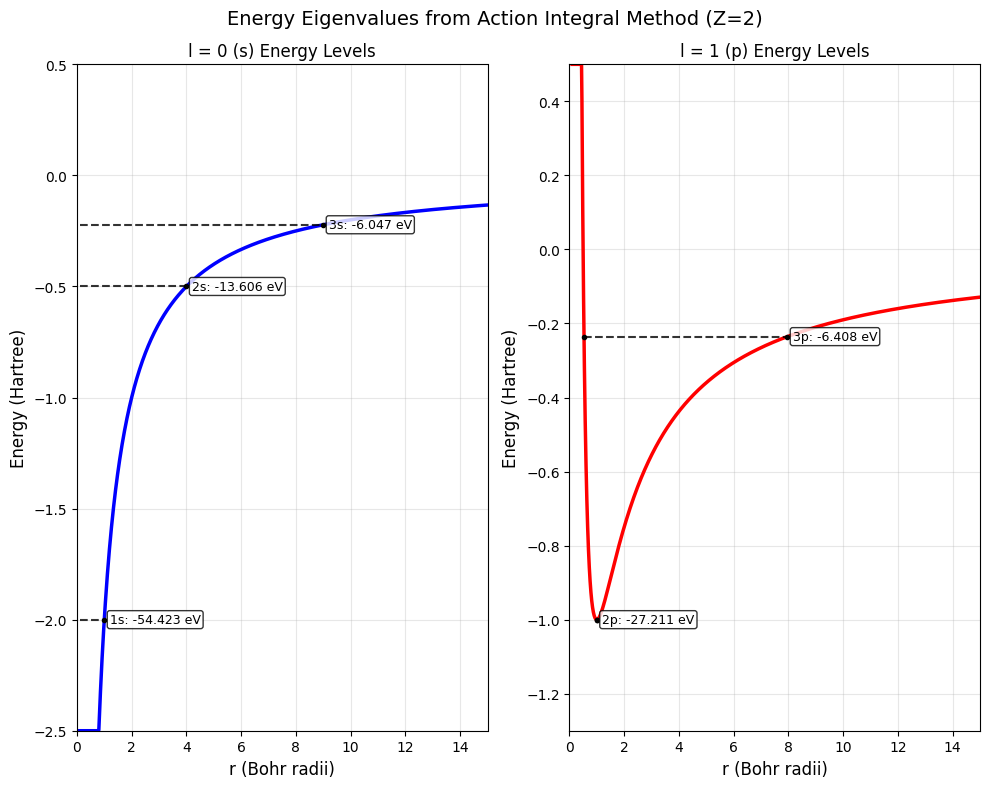

In [34]:
Z = 2

# Calculate all energy levels
energy_levels = calculate_energy_levels(n_max=3, l_max=1, Z=Z)

# Visualize energy levels on potentials
plot_energy_levels_on_potential(energy_levels, Z=Z, l_values=[0, 1], r_max=15)